In [2]:
import pandas as pd
import numpy as np

#Data Visualization
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

#Spiltting the data
from sklearn.model_selection import train_test_split

#token Vectoriser and encoding categorical variable
import nltk
import string
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder

#pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer

#models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#model performance metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

We will now load the dataset which was cleaned as part of the EDA and will check the overview of the dataset.

In [3]:
#Loading the data
df = pd.read_csv('Data/fake_job_posting_clean.csv')
df.head()

,Unnamed: 0,country,has_company_logo,employment_type,required_experience,required_education,function,fraudulent,text
0,0,US,1,Other,Internship,Unspecified,Marketing,0,"Marketing Intern We're Food52, and we've creat..."
1,1,NZ,1,Full-time,Not Applicable,Unspecified,Customer Service,0,Customer Service - Cloud Video Production 90 S...
2,2,US,1,Other,Not Applicable,Unspecified,Other,0,Commissioning Machinery Assistant (CMA) Valor ...
3,3,US,1,Full-time,Mid-Senior level,Bachelor's Degree,Sales,0,Account Executive - Washington DC Our passion ...
4,4,US,1,Full-time,Mid-Senior level,Bachelor's Degree,Health Care Provider,0,Bill Review Manager SpotSource Solutions LLC i...


In [4]:
##Removing the index column
df.drop('Unnamed: 0', axis=1, inplace = True)

We can see that the index column is duplicated in the new data file.\
Let us drop the 'Unnamed: 0' column from our dataset. 

In [6]:
df.head()

,country,has_company_logo,employment_type,required_experience,required_education,function,fraudulent,text
0,US,1,Other,Internship,Unspecified,Marketing,0,"Marketing Intern We're Food52, and we've creat..."
1,NZ,1,Full-time,Not Applicable,Unspecified,Customer Service,0,Customer Service - Cloud Video Production 90 S...
2,US,1,Other,Not Applicable,Unspecified,Other,0,Commissioning Machinery Assistant (CMA) Valor ...
3,US,1,Full-time,Mid-Senior level,Bachelor's Degree,Sales,0,Account Executive - Washington DC Our passion ...
4,US,1,Full-time,Mid-Senior level,Bachelor's Degree,Health Care Provider,0,Bill Review Manager SpotSource Solutions LLC i...


Let us now split the dataset into training and test dataset before we perform any data preprocessing in our dataset.

In [9]:
## Train Test Split of data
X = df.drop('fraudulent', axis =1)
y = df['fraudulent']

X_train,X_test, y_train,y_test = train_test_split(X,y,test_size = 0.20, stratify = y, random_state = 1)

We will now define our tokeniser. 
1. Using the string package we will first remove the punctuations in our text and convert them to lower case.
2. Then split the words into token using space as a delimiter
3. Then we check if the word is present in stop words list from nltk.
4. If present, those words are dropped else the words are stemmed usingthe nltk stemmer function.

In [8]:
nltk.download('stopwords')
stemmer = nltk.stem.PorterStemmer()

from nltk.corpus import stopwords 
ENGLISH_STOP_WORDS = stopwords.words('english')

def my_tokenizer(sentence):
    
    for punctuation_mark in string.punctuation:
        # Remove punctuation and set to lower case
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
        
    # Remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jaiganeshkannan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data Preprocessing ###
I used the tokenizer defined above in TF-IDF vectoriser to convert the text column in to vectorised token.

Also for the categorical features `Country`, `employment_type`, `required_education`, `required_experience` and `function` I have used one hot encoder to encode.

**Column Transformation:**\
I will now pass the TF-IDF vetorizer and Onehotencoder into 'ColumnTransformer( )' function to transform the text and the categorical column in our dataset.

**Pipeline:**\
I have used `sklearn.pipeline` and have passed the column transformer first, followed by the model.

### Modelling ###
**Logistic Regression:**\
We will now store the hyper parameter values to be tunned in a list as a dictionary. These parameter will be passed in the grid search for hyper parameter tunning.

For logistic regression I have used C value and penalty as my hyperparameter and have tunned it with few values using grid search.

In [9]:
#set up column transformer parameters

col_transform = [('OHE_transform', OneHotEncoder(handle_unknown = 'ignore'), ['country',
                                                                              'employment_type',
                                                                              'required_education',
                                                                              'required_experience',
                                                                              'function']),
                ('text_transform', 
                 TfidfVectorizer(min_df=20, tokenizer=my_tokenizer, ngram_range = (1,3)), 
                 'text')]

#Setting up the pipeline for execution
pipeline_estimators = [('col_trans', ColumnTransformer(col_transform)),
                      ('model', LogisticRegression())]

pipe = Pipeline(pipeline_estimators)

## Defining the hyperparameter values for grid search
param_grid = [
    {'model': [LogisticRegression(solver='liblinear')],
    'model__C': [0.001,0.01,0.1, 0.3,0.5],
    'model__penalty': ['l1','l2']}]

# Setting up the grid search
grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, verbose=1)

We will now fit the training dataset to the instantiated grid search function

In [14]:
fitted_grid = grid.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 36.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 41.6min finished


We can call the `.best_estimator_` parameter to see the best paramaters for the logistic regression model.

In [15]:
fitted_grid.best_estimator_

Pipeline(memory=None,
         steps=[('col_trans',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('OHE_transform',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='ignore',
                                                                sparse=True),
                                                  ['country', 'employment_type',
                                                   'required_education',
                                                   'required_experience',
                                                 

We can see from the above results that, the grid search has determined that the model with a `C value` of 0.5 and the `penalty` factor of l2 has the best results. Let us now score our test data on our fitted model

In [13]:
print(fitted_grid.score(X_test, y_test))
print(fitted_grid.score(X_train, y_train))

0.9678977272727273
0.9710206690816109


I would like to store the predictions made by the best model using `.predict` function and will check for the confusion matrix to see how many datapoints are misclassified (especially for fraudulent jobs)

In [16]:
y_pred = fitted_grid.predict(X_test)

#Confusion matrix for test set
confusion_matrix(y_test, y_pred)

array([[3347,    2],
       [ 111,   60]])

In [17]:
##Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3349
           1       0.97      0.35      0.52       171

    accuracy                           0.97      3520
   macro avg       0.97      0.68      0.75      3520
weighted avg       0.97      0.97      0.96      3520



Using the `classification report` from sklearn package we have got the recall and precision for the fraudulent jobs. 

We can see that the model though had a very high accuracy of 96.79% but when we look into the recall percentage we could see that we were able to predict only 35% of the data which were actually fraud and missed out on 65% of the fraudulent jobs.

Hence the model performance is not so great in this model. The reason behind such a poor model performance is because the datset is highly imbalanced and hence the model does not have enough information to learn about the fraudulent jobs.

The model is trying to predict most of the jobs to be real.

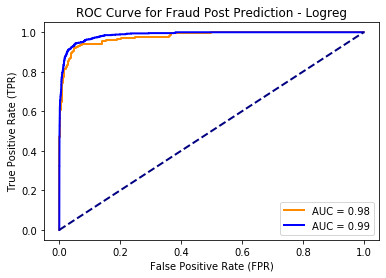

Test AUC score:0.9768456674681627
Train AUC score:0.987185023471671



In [18]:
# Regenerate scores
y_proba_logreg_test = fitted_grid.predict_proba(X_test)[:,1]
y_proba_logreg_train = fitted_grid.predict_proba(X_train)[:,1]

from sklearn.metrics import roc_curve, roc_auc_score

fprs, tprs, thresholds = roc_curve(y_test, y_proba_logreg_test)
roc_auc_logreg_test = roc_auc_score(y_test, y_proba_logreg_test)

fprs_train, tprs_train, thresholds_train = roc_curve(y_train, y_proba_logreg_train)
roc_auc_logreg_train = roc_auc_score(y_train, y_proba_logreg_train)

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc_logreg_test)
plt.plot(fprs_train, tprs_train, color='blue',
         lw=2, label='AUC = %0.2f' % roc_auc_logreg_train)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Fraud Post Prediction - Logreg')
plt.legend(loc="best")
plt.show()

print(f'Test AUC score:{roc_auc_logreg_test}')
print(f'Train AUC score:{roc_auc_logreg_train}')
print()

We have AUC score of 0.977 and 0.987 for test and train dataset respectively. Though the model very confident about its prediction its recall percentage id very low.

Let me now apply the same pipeline for Randomforest and XG Boost model, and check for the model performance metrics.

For random forest model I have used the `n_estimators` and `max_depth` as my hyper-paramter for tunning.

In [20]:
#set up column transformer parameters

col_transform = [('OHE_transform', OneHotEncoder(handle_unknown = 'ignore'), ['country',
                                                                              'employment_type',
                                                                              'required_education',
                                                                              'required_experience',
                                                                              'function']),
                ('text_transform', 
                 TfidfVectorizer(min_df=20, tokenizer=my_tokenizer, ngram_range = (1,3)), 
                 'text')]

pipeline_estimators = [('col_trans', ColumnTransformer(col_transform)),
                      ('model', RandomForestClassifier())]

pipe = Pipeline(pipeline_estimators)

param_grid = [
    {'model': [RandomForestClassifier()],
    'model__n_estimators': [10,20,50,100],
    'model__max_depth': [10,50,100,500,1000]}]


grid_rf = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, verbose=1)

Let us fit the model for the train data.

In [21]:
fitted_grid_rf = grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/jaiganeshkannan/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 36.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 83.5min finished


Let us check the hyper parameter values for the best random forest model after grid search cross validation.

In [22]:
fitted_grid_rf.best_estimator_

Pipeline(memory=None,
         steps=[('col_trans',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('OHE_transform',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='ignore',
                                                                sparse=True),
                                                  ['country', 'employment_type',
                                                   'required_education',
                                                   'required_experience',
                                                 

The random forest model was have its best result with the `n_estimators = 20` and `max_depth=100`. Let us now score the fitted model on the test dataset.

In [23]:
print(fitted_grid_rf.score(X_test, y_test))
print(fitted_grid_rf.score(X_train, y_train))

0.9829545454545454
0.9971588891256481


We have a test accuracy of 0.983 and train accuracy of 0.997. We will now look into the classification report for other model performance metrics.

In [24]:
y_pred_rf = fitted_grid_rf.predict(X_test)

#Confusion matrix for test set
confusion_matrix(y_test, y_pred_rf)

array([[3349,    0],
       [  60,  111]])

In [26]:
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3349
           1       1.00      0.65      0.79       171

    accuracy                           0.98      3520
   macro avg       0.99      0.82      0.89      3520
weighted avg       0.98      0.98      0.98      3520



From the `classification report` ,we can see that random forest model has a recall percentage of 0.65 which is higher than our logistic regression model. Also the model has a precision of 1.00 which means the model was able to classify the real jobs perfectly.

Let us look in to the ROC curve for random forest model.

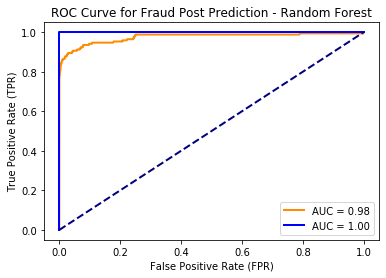

Test AUC score:0.9753561768460166
Train AUC score:0.999998692082412



In [25]:
# Regenerate scores
y_proba_rf_test = fitted_grid_rf.predict_proba(X_test)[:,1]
y_proba_rf_train = fitted_grid_rf.predict_proba(X_train)[:,1]

from sklearn.metrics import roc_curve, roc_auc_score

fprs, tprs, thresholds = roc_curve(y_test, y_proba_rf_test)
roc_auc_rf_test = roc_auc_score(y_test, y_proba_rf_test)

fprs_train, tprs_train, thresholds_train = roc_curve(y_train, y_proba_rf_train)
roc_auc_rf_train = roc_auc_score(y_train, y_proba_rf_train)

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc_rf_test)
plt.plot(fprs_train, tprs_train, color='blue',
         lw=2, label='AUC = %0.2f' % roc_auc_rf_train)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Fraud Post Prediction - Random Forest')
plt.legend(loc="best")
plt.show()

print(f'Test AUC score:{roc_auc_rf_test}')
print(f'Train AUC score:{roc_auc_rf_train}')
print()

The model looks very confident with the AUC score of 0.975 and 0.999 for test and train dataset respectively.

We will now run the model with XG boost and will check for the model performance. I have used `learning_rate`, `max_depth` and `n_estimator` as my hyperparameter for tuning.

In [10]:
#set up column transformer parameters

col_transform = [('OHE_transform', OneHotEncoder(handle_unknown = 'ignore'), ['country',
                                                                              'employment_type',
                                                                              'required_education',
                                                                              'required_experience',
                                                                              'function']),
                ('text_transform', 
                 TfidfVectorizer(min_df=20, tokenizer=my_tokenizer, ngram_range = (1,3)), 
                 'text')]

pipeline_estimators = [('col_trans', ColumnTransformer(col_transform)),
                      ('model', XGBClassifier())]

pipe = Pipeline(pipeline_estimators)

param_grid = [
    {'model': [XGBClassifier()],
    'model__learning_rate': [0.001,0.01,0.1,0.3,0.5],
    'model__max_depth': [10,50,100,500,1000],
    'model__n_estimators': [10,30,50,100]}]


grid_XGB = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, verbose=1)

Let's fit the model for our trian dataset. Then we will check the hyper parameter values for the best XG boost model.

In [11]:
fitted_grid_XGB = grid_XGB.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 90.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 470.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 867.6min
/Users/jaiganeshkannan/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 945.2min finished


In [12]:
fitted_grid_XGB.best_estimator_

Pipeline(memory=None,
         steps=[('col_trans',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('OHE_transform',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='ignore',
                                                                sparse=True),
                                                  ['country', 'employment_type',
                                                   'required_education',
                                                   'required_experience',
                                                 

Our best model for XG boost has the `learning_rate = 0.3`, `n_estimators = 100` and `max_depth=50`. Let us now score the test dataset on the fitted model.

In [13]:
print(fitted_grid_XGB.score(X_test, y_test))
print(fitted_grid_XGB.score(X_train, y_train))

0.9869318181818182
1.0


We have a test accuracy of 0.987 and a perfect train accuracy of 1.0. We will now look into the classification report for other model performance metrics.

In [14]:
y_pred_XGB = fitted_grid_XGB.predict(X_test)

#Confusion matrix for test set
confusion_matrix(y_test, y_pred_XGB)

array([[3345,    4],
       [  42,  129]])

In [15]:
print(classification_report(y_test,y_pred_XGB))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3349
           1       0.97      0.75      0.85       171

    accuracy                           0.99      3520
   macro avg       0.98      0.88      0.92      3520
weighted avg       0.99      0.99      0.99      3520



From the `classification report` we can see that XG Boost model has a recall percentage of 0.75 which is higher than our logistic regression model and random forest model. It looks like XG boost was able to handle th eclass imbalance much better than other two models.
Let us look in to the ROC curve for XG Boost model.

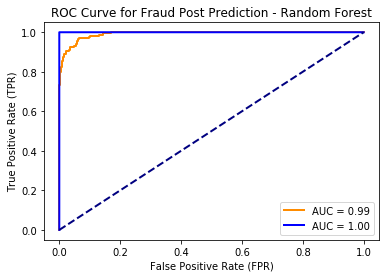

Test AUC score:0.9914559465250166
Train AUC score:1.0



In [16]:
# Regenerate scores
y_proba_XGB_test = fitted_grid_XGB.predict_proba(X_test)[:,1]
y_proba_XGB_train = fitted_grid_XGB.predict_proba(X_train)[:,1]

from sklearn.metrics import roc_curve, roc_auc_score

fprs, tprs, thresholds = roc_curve(y_test, y_proba_XGB_test)
roc_auc_XGB_test = roc_auc_score(y_test, y_proba_XGB_test)

fprs_train, tprs_train, thresholds_train = roc_curve(y_train, y_proba_XGB_train)
roc_auc_XGB_train = roc_auc_score(y_train, y_proba_XGB_train)

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc_XGB_test)
plt.plot(fprs_train, tprs_train, color='blue',
         lw=2, label='AUC = %0.2f' % roc_auc_XGB_train)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Fraud Post Prediction - XG Boost')
plt.legend(loc="best")
plt.show()

print(f'Test AUC score:{roc_auc_XGB_test}')
print(f'Train AUC score:{roc_auc_XGB_train}')
print()

The model looks very confident with the AUC score of 0.991 and 1.0 for test and train dataset respectively.

I will now over sample my dataset using SMOTE( ) technique and rerun the above models in the over sampled dataset to check if the model is able to perform better on a balanced dataset. Please see the model results for the SMOTE( ) dataset in `SMOTE_dataset.ipynb` file.